## Intonation analysis example

### Imports

In [53]:
# numpy and matplotlib-related
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline  

In [54]:
# other funky imports
import bz2
from xml.etree import ElementTree

### Constants and helper functions

In [55]:
fs = 44100

In [56]:
def freq2pitch(f):
    return 69.0 + 12.0 * np.log2(f*1.0/440.0)

### Reference data
This is just the equivalent of the score. We provide the nominal pitches of Happy Birthday in semitones, with one repeat.

In [57]:
plt.rcParams['figure.figsize'] = [10.0,4.0]
plt.rc('savefig', dpi = 80)

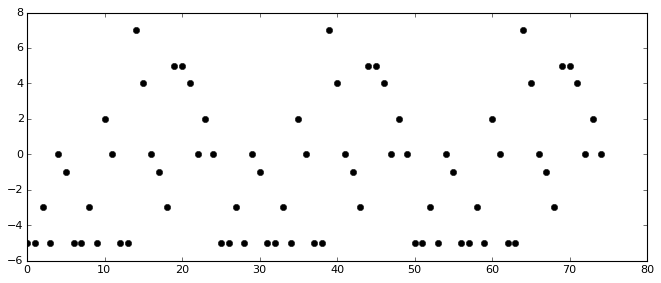

In [58]:
score_pitch = [-5,-5,-3,-5,0,-1,-5,-5,-3,-5,2,0,-5,-5,7,4,0,-1,-3,5,5,4,0,2,0]
score_pitch = score_pitch * 3
score_int   = [np.nan]
score_int = np.hstack([np.array([np.nan]), np.diff(score_pitch)])
plt.plot(score_pitch, 'ko')
plt.show()

### Load note data

In [59]:
def load_notes(fn):
    ''' load data table and derive some columns'''
    note_table = pd.read_csv(fn, header=None)
    note_table.columns = ['onset','frequency', 'duration']
    note_table['p'] = freq2pitch(note_table['frequency'])
    intervals = np.diff(note_table.p)
    intervals = np.insert(intervals, 0, [np.nan])
    note_table['interval'] = intervals
    return note_table
    
notes1 = load_notes('data/happy_birthday_mm_normal.csv')

In [60]:
# just quickly show what's in one of them
notes1.head()

,onset,frequency,duration,p,interval
0,7.029841,136.176,0.382404,48.695627,NaN
1,7.412245,137.787,0.227120,48.899235,0.203608
2,7.656780,153.813,0.580499,50.804087,1.904852
3,8.266304,136.986,0.586304,48.798299,-2.005788
4,8.875828,185.961,0.592109,54.089959,5.291660


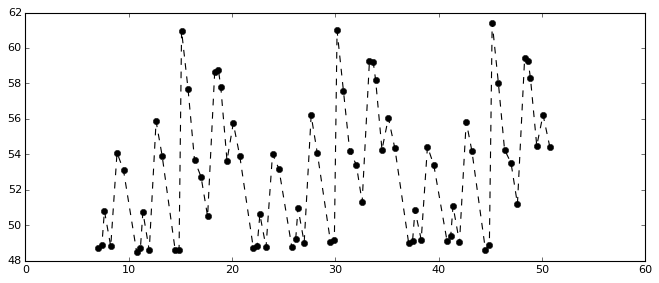

In [61]:
# first
plt.plot(notes1.onset, notes1.p, 'ko')
plt.plot(notes1.onset, notes1.p, 'k--')
plt.show()

### Interval error

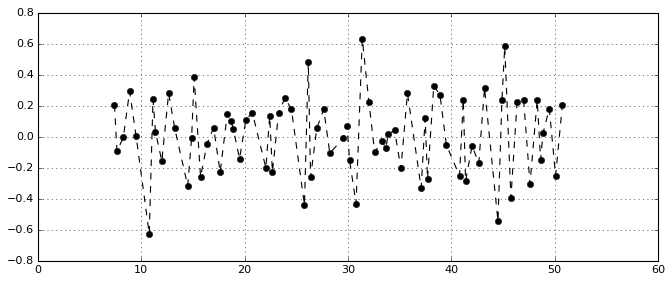

In [62]:
interval_error1 = notes1.interval - score_int
plt.plot(notes1.onset, interval_error1, 'ko')
plt.plot(notes1.onset, interval_error1, 'k--')
plt.grid()

In [63]:
# mean absolute interval error
MAIE1 = np.nanmean(abs(interval_error1))
print "MAIE =", MAIE1

MAIE = 0.205409788352


### Local tonic and drift

In [64]:
local_tonic1 = notes1.p - score_pitch

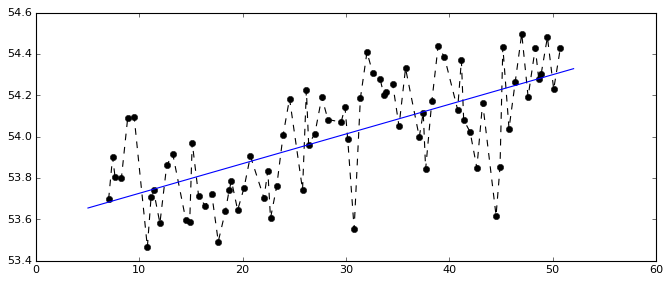

In [65]:
# plot "local tonic"
plt.plot(notes1.onset, local_tonic1, 'ko')
plt.plot(notes1.onset, local_tonic1, 'k--')
from scipy.stats import linregress

# regression plus regression line
slope, intercept, r_value, p_value, std_err = linregress(notes1.onset,local_tonic1)
x = np.arange(min(notes1.onset)-2, max(notes1.onset)+2)
plt.plot(x, slope * x + intercept)
plt.show()

In [66]:
print "The slope is {0:0.3f} cents {1:0.05f} semitones per second.".format(slope * 100, slope)

The slope is 1.435 cents 0.01435 semitones per second.


### A new recording

In [67]:
notes2 = load_notes('data/happy_birthday_kk_new.csv')
interval_error2 = notes2.interval - score_int
MAIE2 = np.nanmean(abs(interval_error2))
print "MAIE2 =", MAIE2

MAIE2 = 0.276906906316


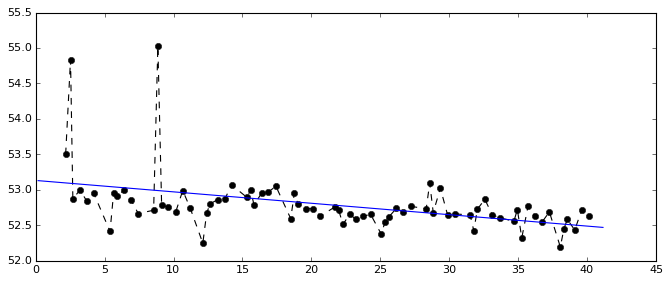

In [68]:
# plot "local tonic"
local_tonic2 = notes2.p - score_pitch
plt.plot(notes2.onset, local_tonic2, 'ko')
plt.plot(notes2.onset, local_tonic2, 'k--')
from scipy.stats import linregress

# regression plus regression line
slope, intercept, r_value, p_value, std_err = linregress(notes2.onset,local_tonic2)
x = np.arange(min(notes2.onset)-2, max(notes2.onset)+2)
plt.plot(x, slope * x + intercept)
plt.show()

In [69]:
print "The slope is {0:0.3f} cents {1:0.05f} semitones per second.".format(slope * 100, slope)

The slope is -1.610 cents -0.01610 semitones per second.


## Slightly advanced loading
One can export a pitch track as well. The Tony session file (.ton) contains both, so here I show a dirty way of extracting both and plotting something.

In [70]:
# functions to load data
def decode_dataset(ds):
    out = [dict(point.items()) for point in ds]
    return out
def load_pitch_from_ton(ton_fn):
    f = bz2.BZ2File(ton_fn) # ton files are really xml hidden in bzip2 files!
    data = ElementTree.parse(f)
    ds0, ds1 =  data.getroot().find('data').findall('dataset')
    ds0dim = [int(d[1]) for d in ds0.items() if d[0] == 'dimensions']
    if ds0dim == 4:
        note_ds = ds0
        pitch_ds = ds1
    else:
        note_ds = ds1
        pitch_ds = ds0
    return decode_dataset(note_ds), decode_dataset(pitch_ds)

In [71]:
# functions to extract information from note dictionaries
def get_pitch(notes):
    return [freq2pitch(float(n['value'])) for n in notes]
def get_onset(notes):
    return [int(n['frame']) * 1.0 / fs for n in notes]
def get_duration(notes):
    return [int(n['duration']) * 1.0 / fs for n in notes]
def get_pitchtrack(pitches):
    times = [int(p['frame']) * 1.0 / fs for p in pitches]
    pitch = [freq2pitch(float(p['value'])) for p in pitches]
    return times, pitch

### Load and prepare singing data

We're just going to import a couple of .ton files, each with 2 consecutive runs of Happy Birthday.

In [72]:
notes, pitches = load_pitch_from_ton("data/happy_birthday_mm_normal.ton")


In [73]:
note_p = get_pitch(notes)
note_t = get_onset(notes)
note_d = get_duration(notes)
note_i = np.hstack([np.array([np.nan]), np.diff(note_p)])
ptimes, ppitch = get_pitchtrack(pitches)

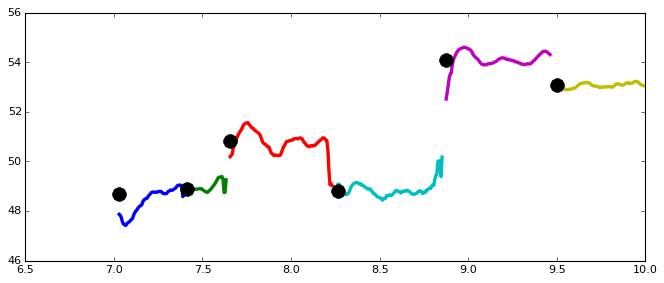

In [74]:
for i, onset in enumerate(note_t):
    ind = (np.array(ptimes) >= onset) & \
          (np.array(ptimes) < (onset + note_d[i]))
    plt.plot(np.array(ptimes)[ind],np.array(ppitch)[ind], linewidth=3.0)
plt.plot(note_t, note_p, 'ko', markersize = 12)
plt.xlim(6.5, 10)
plt.ylim(46, 56)
plt.show()